In [1]:
from MDAnalysis.analysis import align
import MDAnalysis as mda
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib as mpl


/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
from deeptime.clustering import KMeans
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.decomposition import TICA

In [3]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from deeptime.decomposition import VAMP
from MDAnalysis.lib.distances import distance_array
from MDAnalysis.analysis import align

topology_file = './ref.tpr'
trajectory_files = ['./md-1.xtc', './md-2.xtc', 
                    './md-3.xtc', './md-4.xtc',
                    './md-5.xtc'] 

universe = mda.Universe(topology_file, trajectory_files)


/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [5]:
pairwise_distances1 = []
com_distances1 = []
for traj in trajectory_files:
    universe = mda.Universe(topology_file, traj)
    
    protein1_residues = universe.select_atoms('index 0-660 and name BB')  
    protein2_residues = universe.select_atoms('index 661-1321 and name BB') 
    
    selected_residues1 = protein1_residues[::1]
    selected_residues2 = protein2_residues[::1]

    for ts in universe.trajectory:
        
        vector1 = protein1_residues[160].position - protein1_residues[-20].position
        vector2 = protein2_residues[160].position - protein2_residues[-20].position

        dot_product = np.dot(vector1, vector2)
        
        com1 = protein1_residues.center_of_mass()
        com2 = protein2_residues.center_of_mass()
        com_distance = np.linalg.norm(com1 - com2) 
        
        dist = distance_array(selected_residues1.positions, selected_residues2.positions)
        
        pairwise_distances1.append(np.concatenate((np.array(np.diag(dist)), [com_distance])))#, ))) #, [dot_product])))
        #pairwise_distances1.append(np.concatenate((dist.flatten(), [com_distance], [dot_product])))
        com_distances1.append(com_distance)
        

In [6]:
pairwise_distances1=np.array(pairwise_distances1)

In [22]:
def read_xvg(file):
    data = np.loadtxt(file,comments=('@','#'))
    return data

all_data = []
for i in range(5):
    data_LJ = read_xvg(f'./rerun/energy_lj{i+1}.xvg')
    data_Q = read_xvg(f'./rerun/energy_q{i+1}.xvg')

    total_ie = data_LJ[:,1] + data_Q[:,1]
    all_data.append(total_ie)
    
ie = np.concatenate(all_data)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(np.array(pairwise_distances1))


In [26]:
clusterer = KMeans(n_clusters=12, max_iter=10000) 
clustering = clusterer.fit(X_pca.reshape(-1, 6)).fetch_model()
microstate_trajs = clustering.transform(X_pca.reshape(-1, 6))


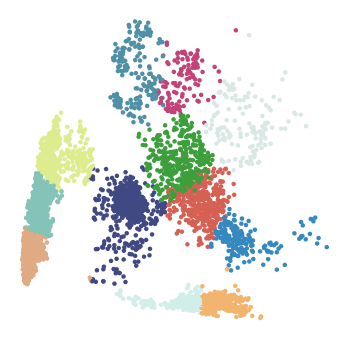

In [27]:
from matplotlib.colors import ListedColormap

pca1 = X_pca[:, 0] 
pca2 = X_pca[:, 1]

fig, ax2 = plt.subplots(figsize=(6, 6))

discrete_colors = [
    '#3589be', # 蓝
    '#84c3b7', # 蓝绿
    '#414985', # 紫
    '#3D9F3C', # 绿色
    '#d46153', # 淡红
    '#f2b56f',  # 黄
    '#ddec8e', # 亮黄
    '#c34278', # 梅红
    '#dae8e5', # 淡青灰色
    '#4f90a6', #淡蓝色
    '#e0aa82', # 土色
    '#d1eeea', #淡蓝
]
cmap = ListedColormap(discrete_colors)

ax.scatter(pca1, pca2, c=microstate_trajs, cmap=cmap, alpha=1, marker='.', s=80, edgecolors='none')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])
  
plt.savefig('pca_cluster.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(pca1, pca2, c='Blues', cmap=ie, alpha=1, marker='.', s=80, edgecolors='none')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])
  
plt.savefig('pca_cluster_ie.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)